# Tiền xử lý dữ liệu

In [3]:
!pip install underthesea

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 22.4 MB/s eta 0:00:00


## Import thư viện cần dùng

In [5]:
# System library
import os
import time
import pickle
import warnings
from collections import defaultdict

# Statistics library
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Natural Language Toolkit
import nltk
import gensim
import underthesea as uts

# utils methods
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

# decompression methods
from sklearn.decomposition import TruncatedSVD

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [6]:
SEED = 42
RANDOM_STATE=123
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set(rc = {'figure.figsize':(15, 10)})
np.random.seed(SEED)

DATA_PATH = 'data/'
MODEL_PATH = 'model/'

## Phần I: Phân tích, tiền xử lý
Trong phần này, chúng ta sẽ tiến hành các bước để phân tích cơ bản về dữ liệu thu được và tiền xử lý chúng trước khi cho vào các mô hình học máy để tiến hành học

### Đọc các dữ liệu cần dùng

In [7]:
# read dantri.json file
dantri = pd.read_json(os.path.join(DATA_PATH, 'dantri.json'))

# read vietnamese stopwords
with open(os.path.join(DATA_PATH, 'vietnamese-stopwords.txt'), 'r') as f:
  stopwords = [line.rstrip("\n").strip().replace(' ', '_') for line in f]

In [8]:
# print first 5 object
dantri.head()

,title,category,content
0,"Thi hành án dứt điểm những vụ lớn, phức tạp li...",Xã hội,"Ông Nguyễn Văn Sơn, Phó Tổng cục trưởng Tổng c..."
1,"Món quà của Thủ tướng dành cho những người ""kh...",Xã hội,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph..."
2,Thủ tướng thị sát đường sắt Nhổn - ga Hà Nội: ...,Xã hội,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph..."
3,Đại sứ Saudi Arabia: Mong muốn Việt Nam sớm vư...,Xã hội,Thủ tướng Phạm Minh Chính tiếp Đại sứ Saudi Ar...
4,"Tổng Thanh tra Chính phủ nói về giải pháp ""trị...",Xã hội,Tổng Thanh tra Chính phủ Đoàn Hồng Phong vừa c...


In [9]:
# remove `Nhân ái` class
dantri = dantri[dantri['category'] != 'Nhân ái']

In [10]:
dantri.shape

(13331, 3)

In [11]:
(dantri['category'].value_counts() / dantri.shape[0])*100

category
Thể thao        11.229465
Giáo dục        10.606856
Sức khỏe         9.526667
Bất động sản     9.219113
Kinh doanh       8.266447
Văn hóa          7.831370
Xã hội           7.253769
Xe ++            6.826195
Sức mạnh số      6.001050
Thế giới         5.693496
Việc làm         5.490961
Giải trí         4.500788
An sinh          4.485785
Pháp luật        3.068037
Name: count, dtype: float64

In [12]:
# print first 5 words in stopwords
stopwords[:5]

['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy']

### Phân tích dữ liệu

In [13]:
print(f"Dataset gồm {dantri.shape[0]} observations và {dantri.shape[1]} features")

Dataset gồm 13331 observations và 3 features


#### Remove NaN values

In [14]:
dantri.isna().sum()

title       0
category    0
content     0
dtype: int64

Dữ liệu trên không có giá trị nào NaN cả nên chúng ta không cần phải loại bỏ chúng

In [15]:
data = dantri[['content', 'category']]

Tổng có 15 hạng mục được thu về, tuy nhiên, có những bài báo rất ngắn vì nó chứa video, vì vậy chúng ta có thể chọn ra ngưỡng cho từng hạng mục để tránh việc bị Overfitting

#### Biểu đồ cột phân bố số lượng bài báo trên từng hạng mục

In [16]:
count = data["category"].value_counts()
num_of_post_each_topic = pd.DataFrame(
    {"category": count.index, "count": count.values}
)
num_of_post_each_topic

,category,count
0,Thể thao,1497
1,Giáo dục,1414
2,Sức khỏe,1270
3,Bất động sản,1229
4,Kinh doanh,1102
5,Văn hóa,1044
6,Xã hội,967
7,Xe ++,910
8,Sức mạnh số,800
9,Thế giới,759


In [19]:
def create_bar_plot(df=None, title="Số lượng bài báo trên từng hạng mục", y_arrow=500):
  fig = px.histogram(
    df,
    x='category',
    y='count',
    color='category',
    title=title,
    color_discrete_sequence=px.colors.qualitative.Bold,
  )
  fig.update_yaxes(showgrid=True)  # the y-axis is in dollars
  fig.update_layout(  # customize font and legend orientation & position
      font_family="Arial",
      legend=dict(
          title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
      ),
      yaxis_title="Số lượng bài báo",
      xaxis_title="Hạng mục",
  )


  fig.add_shape(  # add a horizontal "target" line
      type="line",
      line_color="#16FF32",
      line_width=3,
      opacity=1,
      line_dash="dot",
      x0=0,
      x1=1,
      xref="paper",
      y0=df['count'].mean(),
      y1=df['count'].mean(),
      yref="y",
  )

  fig.add_annotation(  # add a text callout with arrow
      text="Số lượng ít nhất", x="Pháp luật", y=y_arrow, arrowhead=1, showarrow=True
  )


  fig.show()

In [20]:
create_bar_plot(df=num_of_post_each_topic)

Với biểu đồ cột ở trên, thấy rằng phân bố `số lượng bài báo` trên từng `hạng mục` là không đồng đều nhau. Điều này có nghĩa là khi chia ngẫu nhiên dữ liệu để xây dựng mô hình có thể xảy ra tình trạng **Imbalanced Data** vì số lượng bài báo của hạng mục đầu tiên trên trung bình mẫu (đường màu xanh) đã gấp hơn 2 lần so với số lượng bài báo thấp nhất (đường mũi tên).

Từ những nhận xét sơ cấp ở trên, chúng ta có thể xem xét đến hiệu suất của mô hình khi đã qua xử lý việc mất cân bằng dữ liệu

In [21]:
categories = data['category'].unique()
categories

array(['Xã hội', 'Việc làm', 'An sinh', 'Văn hóa', 'Thế giới',
       'Kinh doanh', 'Bất động sản', 'Sức mạnh số', 'Thể thao',
       'Sức khỏe', 'Giải trí', 'Giáo dục', 'Xe ++', 'Pháp luật'],
      dtype=object)

In [22]:
data['word_count'] = data['content'].apply(lambda x: len(gensim.utils.simple_preprocess(x)))
data.head()

,content,category,word_count
0,"Ông Nguyễn Văn Sơn, Phó Tổng cục trưởng Tổng c...",Xã hội,618
1,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph...",Xã hội,786
2,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph...",Xã hội,797
3,Thủ tướng Phạm Minh Chính tiếp Đại sứ Saudi Ar...,Xã hội,1228
4,Tổng Thanh tra Chính phủ Đoàn Hồng Phong vừa c...,Xã hội,971


In [23]:
def truncate_data(df, category):
  df_category = df.query(f"`category` == '{category}'")
  describe = df_category['word_count'].describe()
  at_75th = int(describe['75%'])
  at_25th = int(describe['25%'])
  IQR = at_75th - at_25th
  return df_category[(df_category['word_count'] >= at_25th - 1.5*IQR) & (df_category['word_count'] <= at_75th + 1.5*IQR)]


In [24]:
data_dict = {}
for category in categories:
  data_dict[category] = truncate_data(data, category)

In [25]:
data_dict['Xã hội']

,content,category,word_count
0,"Ông Nguyễn Văn Sơn, Phó Tổng cục trưởng Tổng c...",Xã hội,618
1,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph...",Xã hội,786
2,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph...",Xã hội,797
3,Thủ tướng Phạm Minh Chính tiếp Đại sứ Saudi Ar...,Xã hội,1228
4,Tổng Thanh tra Chính phủ Đoàn Hồng Phong vừa c...,Xã hội,971
...,...,...,...
967,"Liên quan đến vụ, gia đình một chủ tịch phường...",Xã hội,500
968,Liên quan tới vụ ô tô nổi bồng bềnh giữa hồ Tâ...,Xã hội,226
969,"Ngày 1/4, trên mạng xã hội xôn xao hình ảnh kè...",Xã hội,231
970,"Tối 31/3, trao đổi với PV Dân trí, ông Phạm Đì...",Xã hội,160


In [26]:
newdata = pd.DataFrame(columns=['content', 'category', 'word_count'])
newdata

,content,category,word_count


In [27]:
for key, value in data_dict.items():
  newdata = pd.concat([newdata, value], ignore_index=True, axis=0)

newdata.reset_index(drop=True, inplace=True)

In [28]:
newdata.shape

(12785, 3)

In [29]:
newdata.head()

,content,category,word_count
0,"Ông Nguyễn Văn Sơn, Phó Tổng cục trưởng Tổng c...",Xã hội,618
1,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph...",Xã hội,786
2,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph...",Xã hội,797
3,Thủ tướng Phạm Minh Chính tiếp Đại sứ Saudi Ar...,Xã hội,1228
4,Tổng Thanh tra Chính phủ Đoàn Hồng Phong vừa c...,Xã hội,971


In [30]:
def create_hist_plot(categories: list[str], df, num_subplots=3, title="Phân phối số lượng từ trong Xã hội - Việc làm - An sinh"):
  fig, ax = plt.subplots(1, num_subplots)
  for idx, category in enumerate(categories):
    df_category = df.query(f"`category` == '{category}'")
    sns.histplot(data=df_category, x="word_count", kde=True, ax=ax[idx])
    ax[idx].set_title(category)
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()



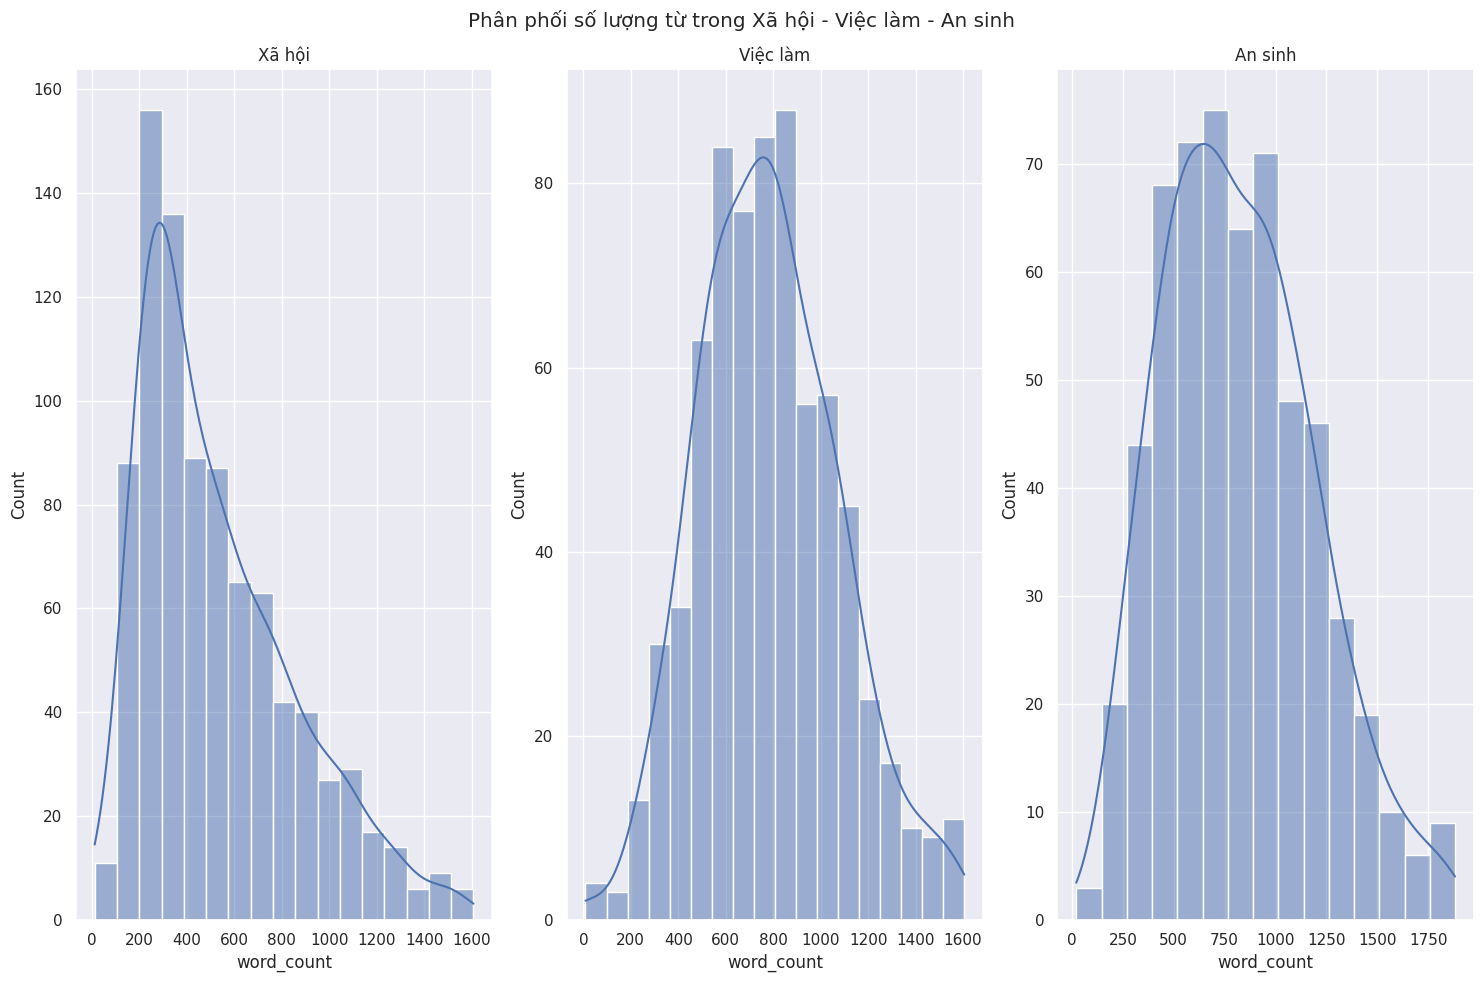

In [31]:
create_hist_plot(categories[:3], df=newdata)

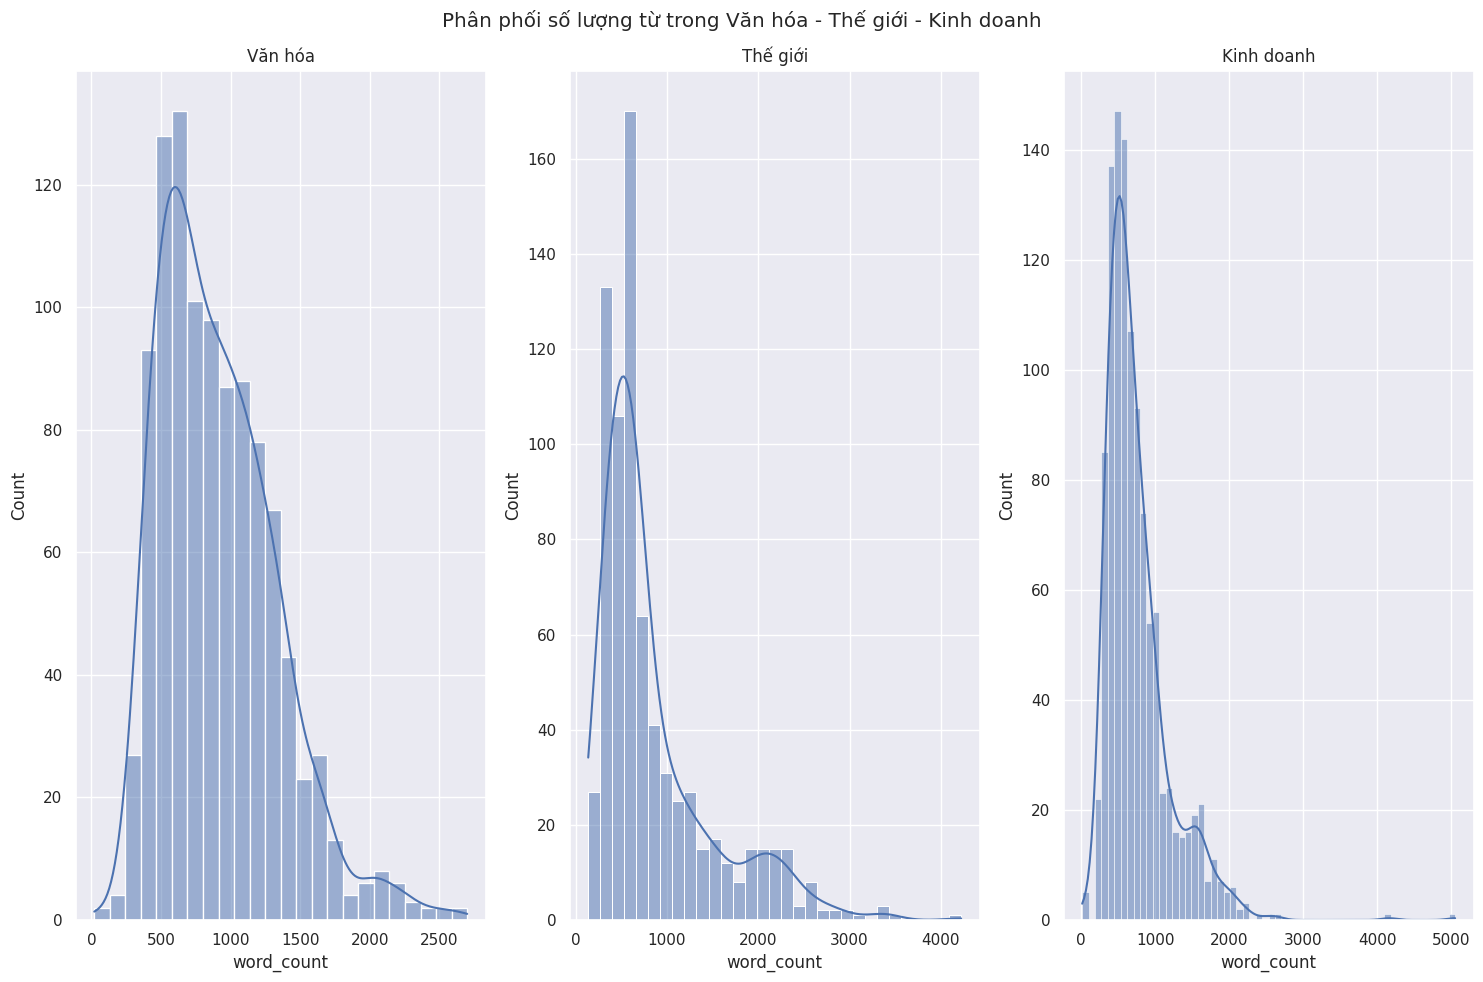

In [32]:
create_hist_plot(categories[3:6], df=data, title="Phân phối số lượng từ trong Văn hóa - Thế giới - Kinh doanh")


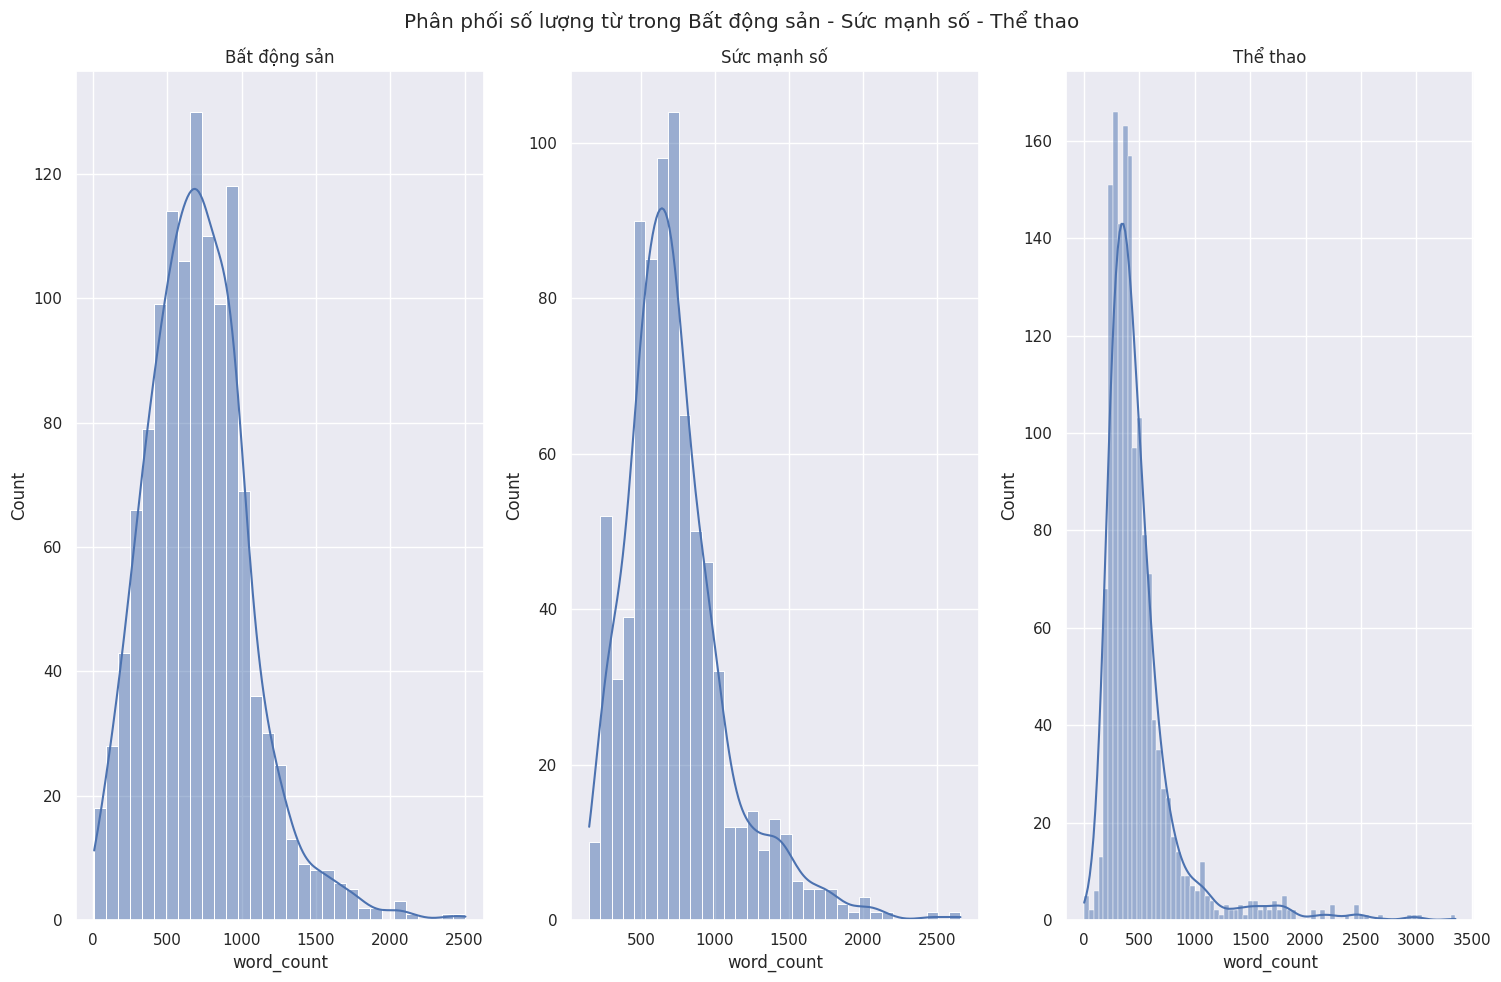

In [33]:
create_hist_plot(categories[6:9], df=data, title="Phân phối số lượng từ trong Bất động sản - Sức mạnh số - Thể thao")


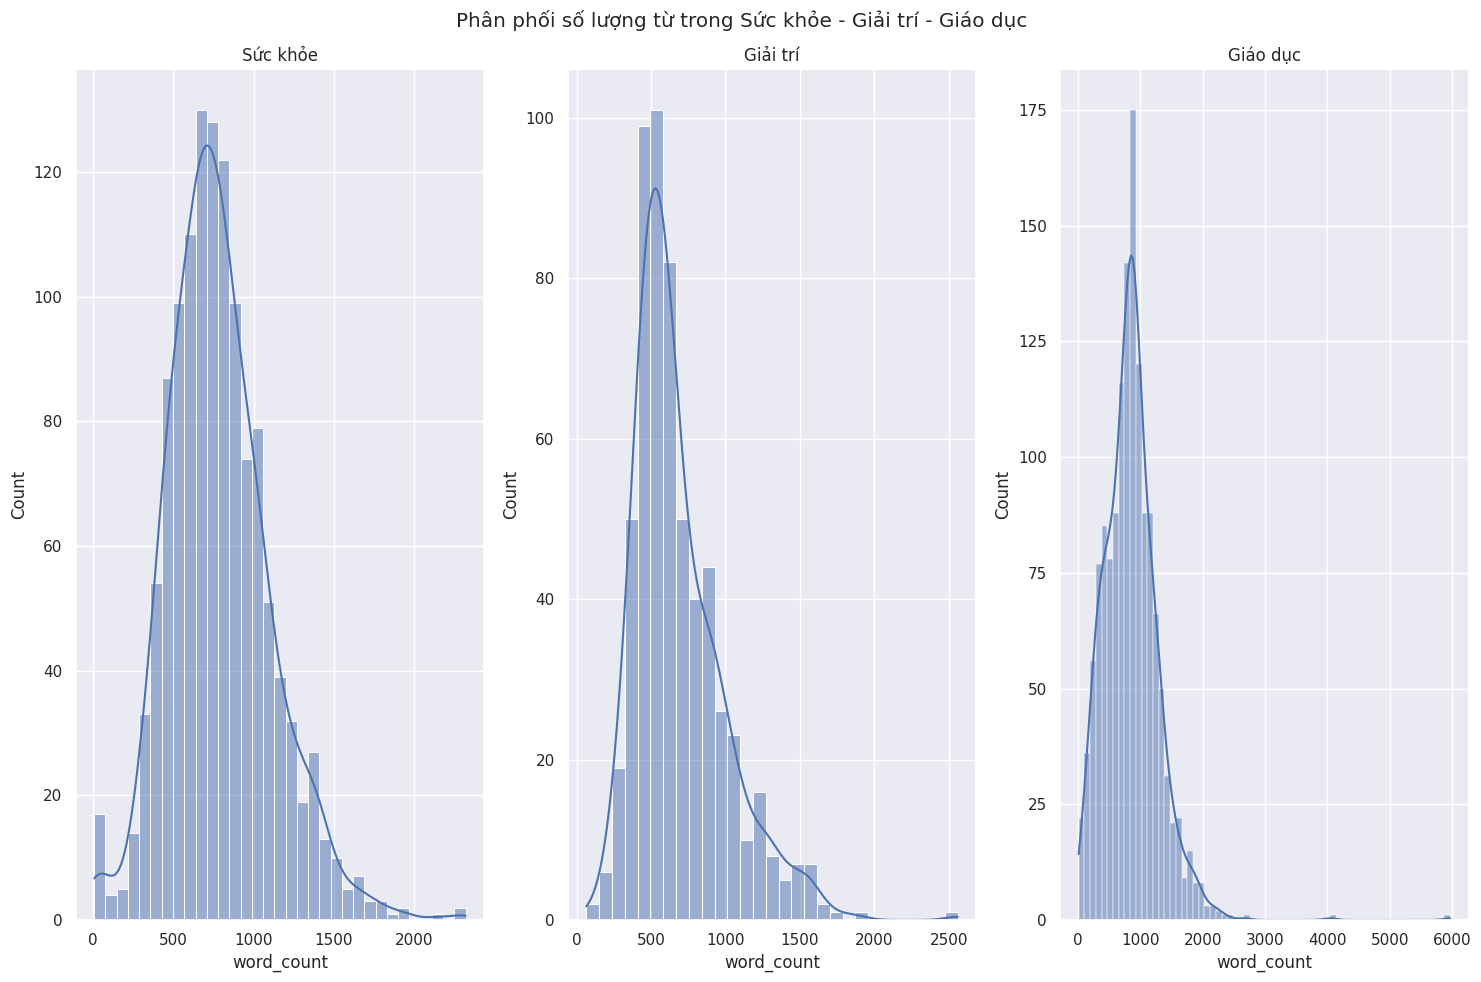

In [34]:
create_hist_plot(categories[9:12], df=data, title="Phân phối số lượng từ trong Sức khỏe - Giải trí - Giáo dục")


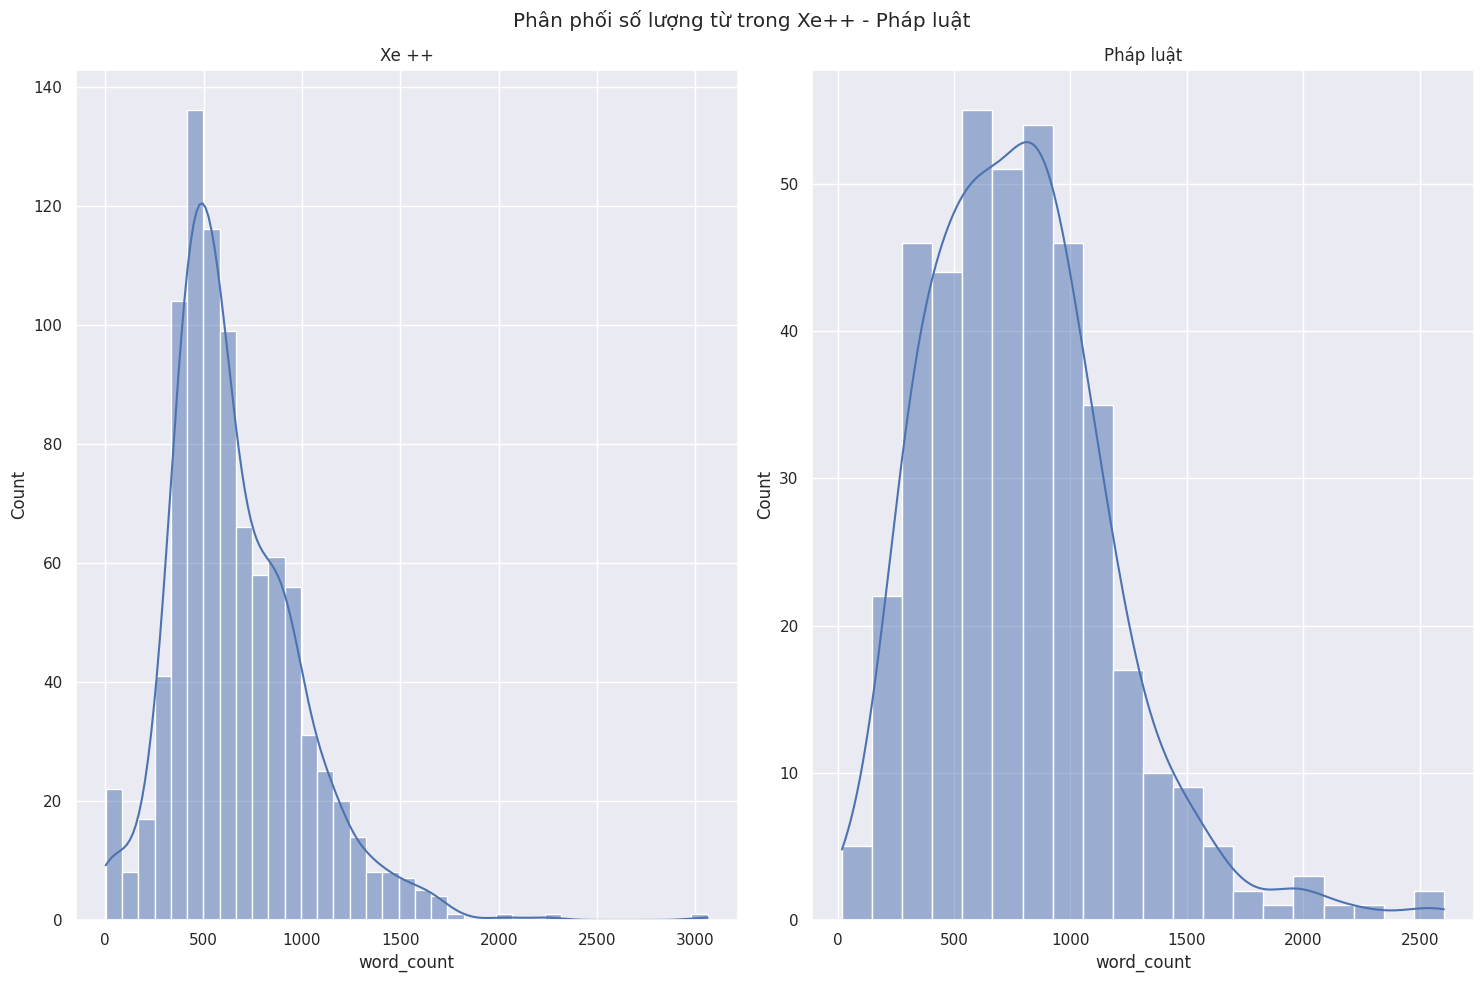

In [35]:
create_hist_plot(categories[12:14], df=data, num_subplots=2, title="Phân phối số lượng từ trong Xe++ - Pháp luật")


Từ các biểu đồ phân phối trên, ta nhận thấy rằng, hầu hết các hạng mục đều tuân theo dạng hình chuông (phân phối Gaussian). Theo lý thuyết, thường phân phối chuẩn sẽ tốt cho mô hình khi học

In [36]:
def create_boxplot(categories, df, title):
  df_categories = df[df['category'].isin(categories)]
  sns.boxplot(data=df_categories, x="category", y="word_count", hue='category')
  plt.title(title)
  plt.tight_layout()
  plt.xlabel("Category")
  plt.ylabel("word_count")
  plt.show()

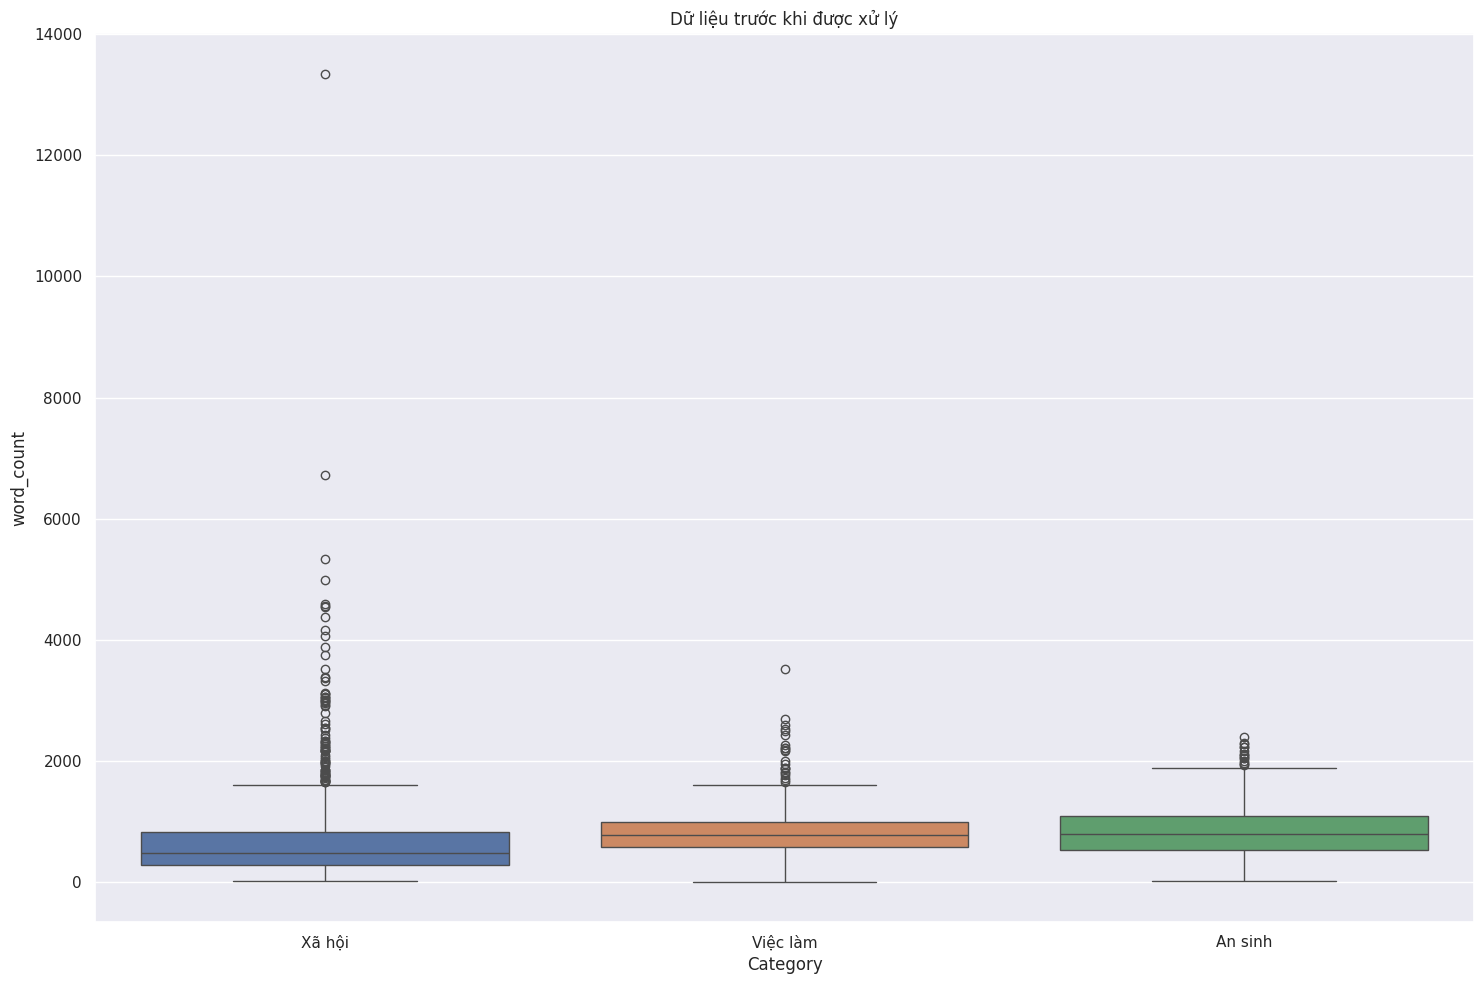

In [37]:
create_boxplot(categories[0:3], data, title="Dữ liệu trước khi được xử lý")

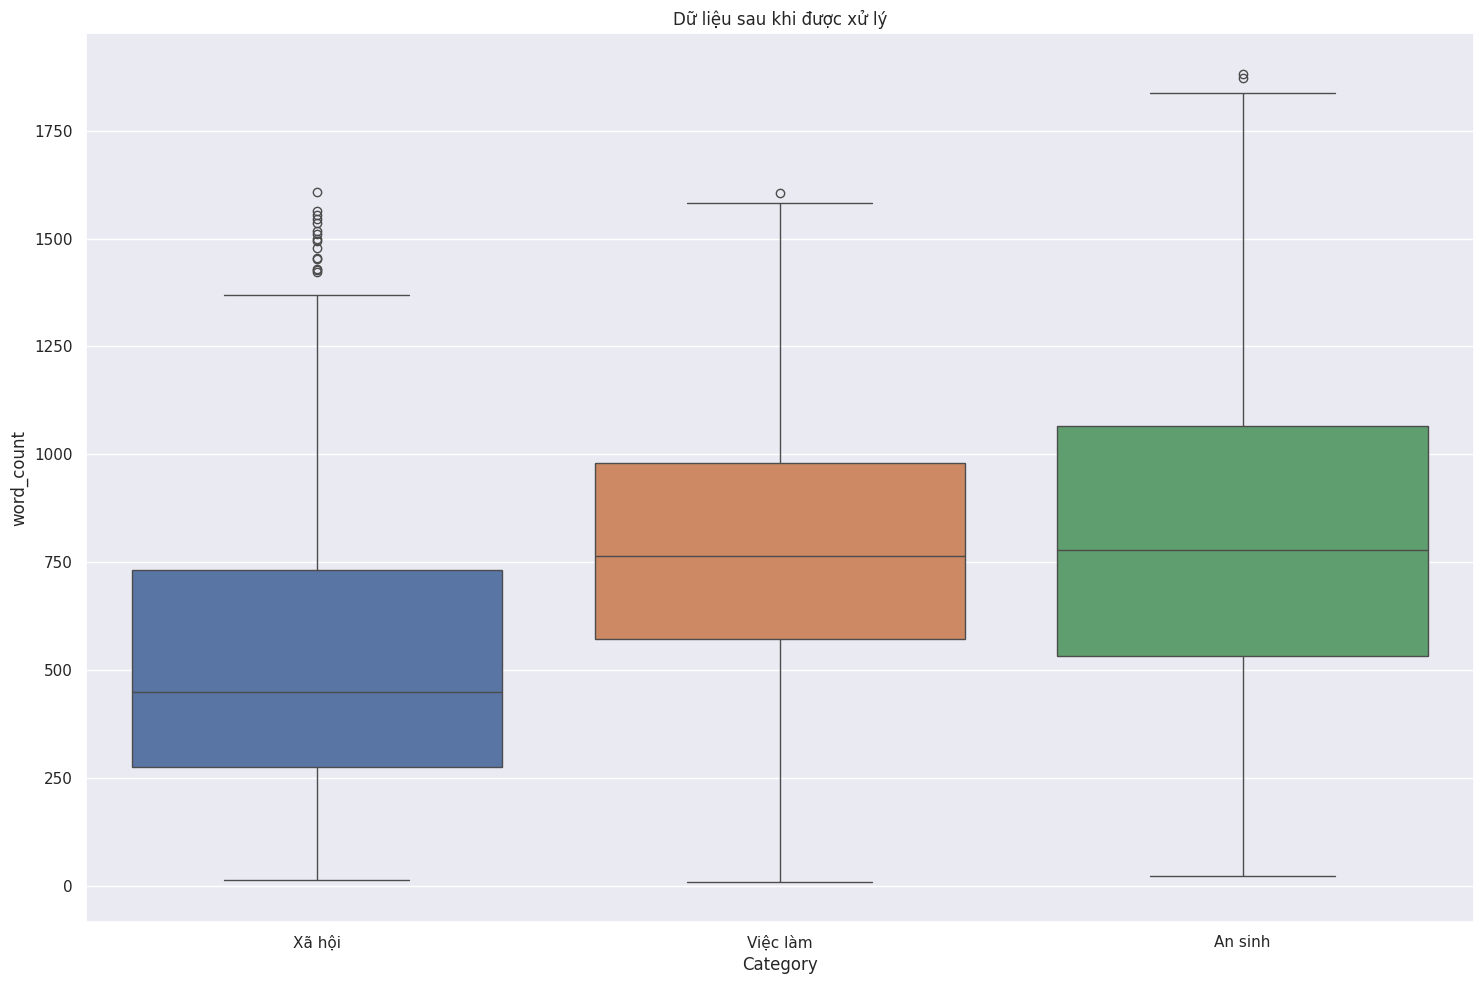

In [38]:
create_boxplot(categories[0:3], newdata, title="Dữ liệu sau khi được xử lý")


In [39]:
count = newdata["category"].value_counts()
num_of_post_each_topic = pd.DataFrame(
    {"category": count.index, "count": count.values}
)

create_bar_plot(df=num_of_post_each_topic)

In [40]:
newdata.shape

(12785, 3)

### Data preprocessing
> Bình thường, trong tiếng Anh sẽ tách ra thành các từ đơn lẻ rồi chuyển sang dạng só thực một cách trực tiếp. Tuy nhiên, trong tiếng Việt sẽ có những từ phải đi cùng một cặp với nhau thì sẽ mang ý nghĩa rõ ràng hơn. Do đó cách xử lý sẽ khác so với tiếng Anh

In [17]:
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        cleaned_texts = []
        for text in X:
            cleaned_text = self.clean_text(text)
            cleaned_texts.append(cleaned_text)
        return np.array(cleaned_texts)

    @staticmethod
    def clean_text(content: str):
        tokens = gensim.utils.simple_preprocess(content)
        content = " ".join(tokens)
        # tokenize content
        content = uts.word_tokenize(content, format='text')

        return content

In [41]:
X, label = newdata['content'].values, newdata['category'].values

print(X.shape, label.shape)

(12785,) (12785,)


In [42]:
print(X[:2])
print(label[:2])

['Ông Nguyễn Văn Sơn, Phó Tổng cục trưởng Tổng cục Thi hành án dân sự (Bộ Tư pháp) vừa ký ban hành kế hoạch công tác năm 2024 của Tổ công tác chỉ đạo xử lý các vụ việc liên quan đến hoạt động tín dụng, ngân hàng (Tổ xử lý nợ xấu). Tổ xử lý nợ xấu có trách nhiệm phối hợp với Vụ Pháp chế (Ngân hàng Nhà nước), Hiệp hội Ngân hàng tổ chức tọa đàm, đối thoại giữa các cơ quan thi hành án với tổ chức tín dụng, Công ty quản lý tài sản (VAMC) để trao đổi, tháo gỡ khó khăn, vướng mắc liên quan đến các vụ việc thi hành án tín dụng, ngân hàng. Trong đó, tập trung rà soát, tổng hợp các vụ việc trên cơ sở thông báo kết luận kiểm tra các năm 2022, 2023 hoặc đề nghị của Hiệp hội Ngân hàng, các tổ chức tín dụng, VAMC. "Phối hợp chỉ đạo tổ chức thi hành dứt điểm đối với những vụ việc có điều kiện, nhất là những đơn vị có nhiều vụ việc lớn, phức tạp liên quan đến các tổ chức tín dụng như Agribank, Vietcombank, VPBank, BIDV, Vietinbank", lãnh đạo Tổng cục Thi hành án dân sự nêu rõ. Ông Nguyễn Văn Sơn, Phó 

In [43]:
le = LabelEncoder()
y = le.fit_transform(label)

print(le.classes_)

['An sinh' 'Bất động sản' 'Giáo dục' 'Giải trí' 'Kinh doanh' 'Pháp luật'
 'Sức khỏe' 'Sức mạnh số' 'Thế giới' 'Thể thao' 'Việc làm' 'Văn hóa'
 'Xe ++' 'Xã hội']


In [ ]:
with open(os.path.join(MODEL_PATH, 'le_.pkl'), 'wb') as f:
  pickle.dump(le, f)

#### Chia dữ liệu thành tập train và test

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

In [45]:
train_category = pd.DataFrame({'category': y_train})
train_category.head()

,category
0,11
1,9
2,12
3,11
4,4


In [46]:
count = train_category["category"].value_counts()
num_of_post_each_topic = pd.DataFrame(
    {"category_le": count.index, "count": count.values}
)
num_of_post_each_topic['category'] = le.inverse_transform(num_of_post_each_topic['category_le'])
num_of_post_each_topic.head()

,category_le,count,category
0,9,974,Thể thao
1,2,972,Giáo dục
2,6,872,Sức khỏe
3,1,843,Bất động sản
4,4,728,Kinh doanh


In [47]:
create_bar_plot(df=num_of_post_each_topic, y_arrow=300)

In [48]:
num_of_post_each_topic['count'].describe()

count     14.000000
mean     639.214286
std      219.603902
min      280.000000
25%      486.500000
50%      620.500000
75%      814.250000
max      974.000000
Name: count, dtype: float64

In [49]:
X_train.shape

(8949,)

#### Xây dựng tệp từ điển

Để có thể khảo sát số lượng từ được phân bố trong từng hạng mục của tập đào tạo (train set), chúng ta sẽ làm một vài phép thống kê sau

In [50]:
train_category_dict = defaultdict(list)
for idx, x in enumerate(X_train):
  category = le.inverse_transform([y_train[idx]])[0]
  train_category_dict[category].append(len(gensim.utils.simple_preprocess(x)))


In [51]:
stats_df = pd.DataFrame(columns=['mean', 'std', 'mean-std', 'mean+std'])
for key, value in train_category_dict.items():
  mean = np.mean(value)
  std = np.std(value)
  min_bound = mean - std
  max_bound = mean + std
  stats_df.loc[key] = np.round([mean, std, min_bound, max_bound], 2)

In [52]:
stats_df

,mean,std,mean-std,mean+std
Văn hóa,878.18,365.38,512.79,1243.56
Thể thao,414.95,159.46,255.49,574.42
Xe ++,635.48,285.85,349.62,921.33
Kinh doanh,677.76,307.81,369.95,985.57
Thế giới,707.65,399.89,307.76,1107.55
Giáo dục,822.91,379.23,443.68,1202.13
Pháp luật,759.16,346.21,412.95,1105.37
Bất động sản,691.72,305.50,386.22,997.22
Sức khỏe,763.67,285.91,477.76,1049.58
Việc làm,771.34,297.95,473.40,1069.29


In [ ]:
# # No Cleaner
# count_vectorizer_no_cleaner = CountVectorizer(stop_words=stopwords)
# count_vectorizer_no_cleaner.fit(X_train)
# MAX_FEATURES = len(count_vectorizer_no_cleaner.vocabulary_)

# With Cleaner
text_cleaner = TextCleaner()
count_vectorizer_with_cleaner = CountVectorizer(stop_words=stopwords)
X_train_with_cleaner = text_cleaner.fit_transform(X_train)
count_vectorizer_with_cleaner.fit(X_train_with_cleaner)
MAX_FEATURES_WITH_CLEANER = len(count_vectorizer_with_cleaner.vocabulary_)

In [ ]:
MAX_FEATURES_WITH_CLEANER #, MAX_FEATURES

97774

#### Tạo Pipeline cho việc tiền xử lý dữ liệu text

In [53]:
# MAX_FEATURES_WITH_CLEANER = 30000
def create_pipeline(stop_words, cleaner=False, max_features=5000, reduction=False, n_components=1000):
  steps = []

  count_vectorizer = CountVectorizer(stop_words=stop_words, max_features=max_features)
  if cleaner:
    text_cleaner = TextCleaner()
    steps.append(('cleaner', text_cleaner))

  # Add steps to convert text to matrix
  steps.append(('count_vectorizer', count_vectorizer))
  steps.append(('tfidf_transformer', TfidfTransformer()))

  if reduction:
    steps.append(('reduction', TruncatedSVD(n_components=n_components)))

  return Pipeline(steps)



#### Chuyển dữ liệu dạng text sang dạng ma trận
Chúng ta sẽ giữ lại khoảng 10% từ vựng, việc giảm số từ vựng xuống giúp cho mô hình giảm độ phức tạp, và chi phí tính toán được giảm thiểu

>

In [54]:
MAX_FEATURES = 5000
N_COMPONENTS = 1000

pipeline = {}
# pipeline['only_cleaner'] = create_pipeline(stopwords, cleaner=True, max_features=MAX_FEATURES)
pipeline['cleaner_and_reduction'] = create_pipeline(stopwords, cleaner=True, max_features=MAX_FEATURES,
                                                    reduction=True, n_components=N_COMPONENTS)

In [55]:
# transform train and test set
# X_train_cleaner_ = pipeline['only_cleaner'].fit_transform(X_train)
# X_test_cleaner_ = pipeline['only_cleaner'].transform(X_test)

X_train_cleaner_and_reduction_ = pipeline['cleaner_and_reduction'].fit_transform(X_train)
X_test_cleaner_and_reduction_ = pipeline['cleaner_and_reduction'].transform(X_test)

In [56]:
with open(os.path.join(MODEL_PATH, 'pipeline.pkl'), 'wb') as f:
  pickle.dump(pipeline['cleaner_and_reduction'], f)


### Save numpy array

In [ ]:
# Save processed data
with open(os.path.join(MODEL_PATH, 'X_train_cleaner_and_reduction_.npy'), 'wb') as f:
  np.save(f, X_train_cleaner_and_reduction_)

with open(os.path.join(MODEL_PATH, 'y_train.npy'), 'wb') as f:
  np.save(f, y_train)

with open(os.path.join(MODEL_PATH, 'X_test_cleaner_and_reduction_.npy'), 'wb') as f:
  np.save(f, X_test_cleaner_and_reduction_)

with open(os.path.join(MODEL_PATH, 'y_test.npy'), 'wb') as f:
  np.save(f, y_test)

In [47]:
# Load processed data
X_train_cleaner_and_reduction_ = np.load(os.path.join(MODEL_PATH, 'X_train_cleaner_and_reduction_.npy'))
X_test_cleaner_and_reduction_ = np.load(os.path.join(MODEL_PATH, 'X_test_cleaner_and_reduction_.npy'))
y_train = np.load(os.path.join(MODEL_PATH, 'y_train.npy'))
y_test = np.load(os.path.join(MODEL_PATH, 'y_test.npy'))

In [ ]:
# print(X_train_cleaner_.shape)
print(X_train_cleaner_and_reduction_.shape, y_train.shape)
print(X_test_cleaner_and_reduction_.shape, y_test.shape)

(8949, 1000) (8949,)
(3836, 1000) (3836,)


In [51]:
print(np.array_str(X_train_cleaner_and_reduction_[0], precision=5, suppress_small=True))

[ 0.1436   0.0073   0.04348  0.06489  0.07521  0.02368  0.14069 -0.0515
  0.04698  0.01958 -0.01282  0.02432  0.02838  0.03989  0.00149  0.05454
 -0.02914 -0.00601 -0.07705 -0.01978  0.03013 -0.01986 -0.00282 -0.00725
 -0.00376  0.01424 -0.00063 -0.00217 -0.02193  0.01754 -0.00026  0.02293
  0.0113   0.01947 -0.01902  0.0028  -0.01127  0.00265  0.01491 -0.03716
  0.00585 -0.00235  0.00621 -0.00957  0.01848 -0.03838 -0.01188  0.01932
  0.00211 -0.00255  0.03467 -0.01134  0.00893 -0.00433 -0.0264  -0.01604
 -0.00821  0.03475 -0.03648  0.00664 -0.02164 -0.02912 -0.01571 -0.00634
 -0.00596  0.01316 -0.00375  0.00467 -0.00565  0.05485  0.02104 -0.03549
 -0.00958  0.03    -0.00499  0.02329  0.01157 -0.00188 -0.03226  0.00995
  0.01694  0.01195  0.0247  -0.03166  0.00368 -0.02152 -0.0322  -0.02496
 -0.03797  0.00252  0.01454 -0.02374  0.02166  0.02161  0.02353 -0.00642
  0.00239  0.01939 -0.01053 -0.02085 -0.01521 -0.00506 -0.00359  0.00771
  0.01777  0.02197 -0.00157  0.0346  -0.00885 -0.001

In [ ]:
le.inverse_transform([y_train[0]])

array(['Sức khỏe'], dtype=object)